# Laboratorio 8
Diego Ruiz

El contexto del problema para este laboratorio es que se tiene un set de datos sobre clientes de un banco de India con mas de 1M de transacciones. Los  bancos, en su mayoría, tienen una gran base de clientes, y se tiene información de estos clientes como lo puede ser su edad, ingresos, valores, estilo de vida, etc. Lo que se busca con este laboratorio es realizar la segmentación de clientes, es decir, dividirlos en grupos específicos basados en características compartidas. Para esto utilizaremos K-means.

In [418]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn import metrics

%matplotlib inline
plt.rcParams['figure.figsize'] = (15, 9)
plt.style.use('ggplot')

### Exploración de Datos
Importamos el dataet y realizamos una breve exploración con los datos para determinar si es necesario realizar limpieza, encoding y/o balanceo.

In [419]:
data = pd.read_csv('bank_transactions.csv')

data.head()

,TransactionID,CustomerID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR)
0,T1,C5841053,10/1/94,F,JAMSHEDPUR,17819.05,2/8/16,143207,25.0
1,T2,C2142763,4/4/57,M,JHAJJAR,2270.69,2/8/16,141858,27999.0
2,T3,C4417068,26/11/96,F,MUMBAI,17874.44,2/8/16,142712,459.0
3,T4,C5342380,14/9/73,F,MUMBAI,866503.21,2/8/16,142714,2060.0
4,T5,C9031234,24/3/88,F,NAVI MUMBAI,6714.43,2/8/16,181156,1762.5


CustAccountBalance


C:\Users\yeyoc\AppData\Local\Temp\ipykernel_9672\638141354.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data[stat])


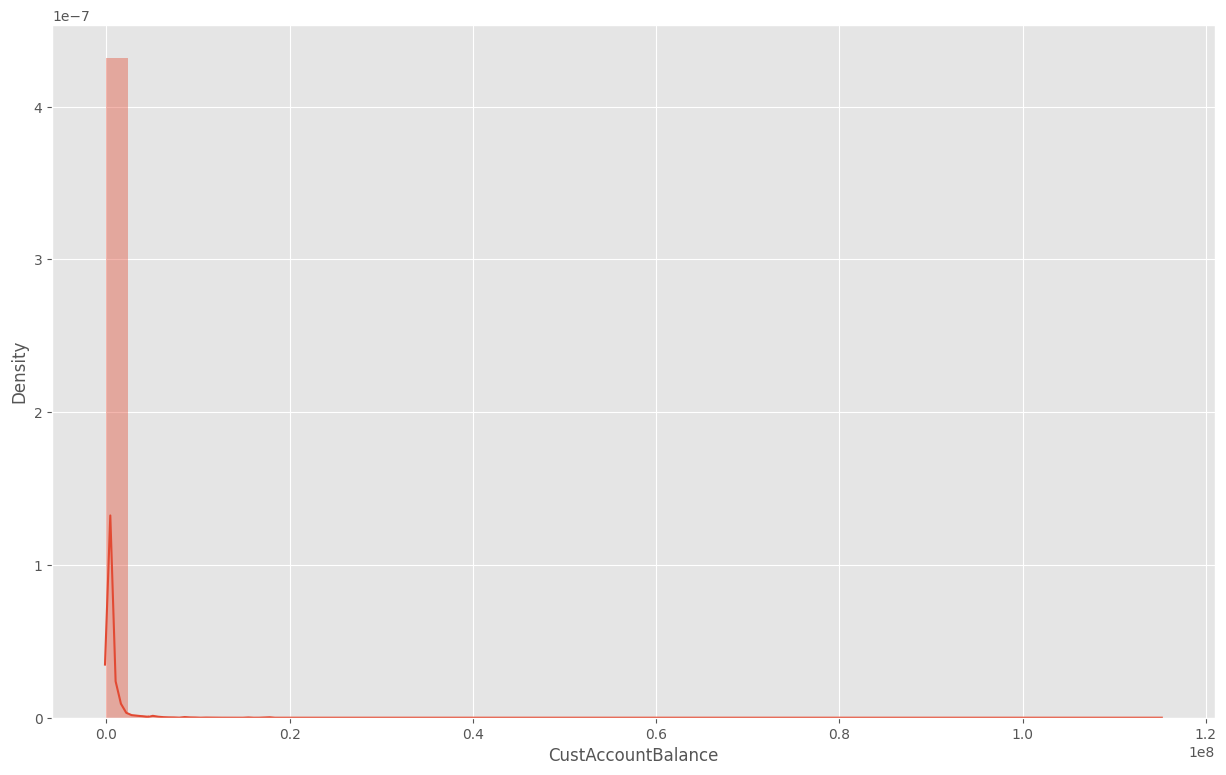

TransactionTime


C:\Users\yeyoc\AppData\Local\Temp\ipykernel_9672\638141354.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data[stat])


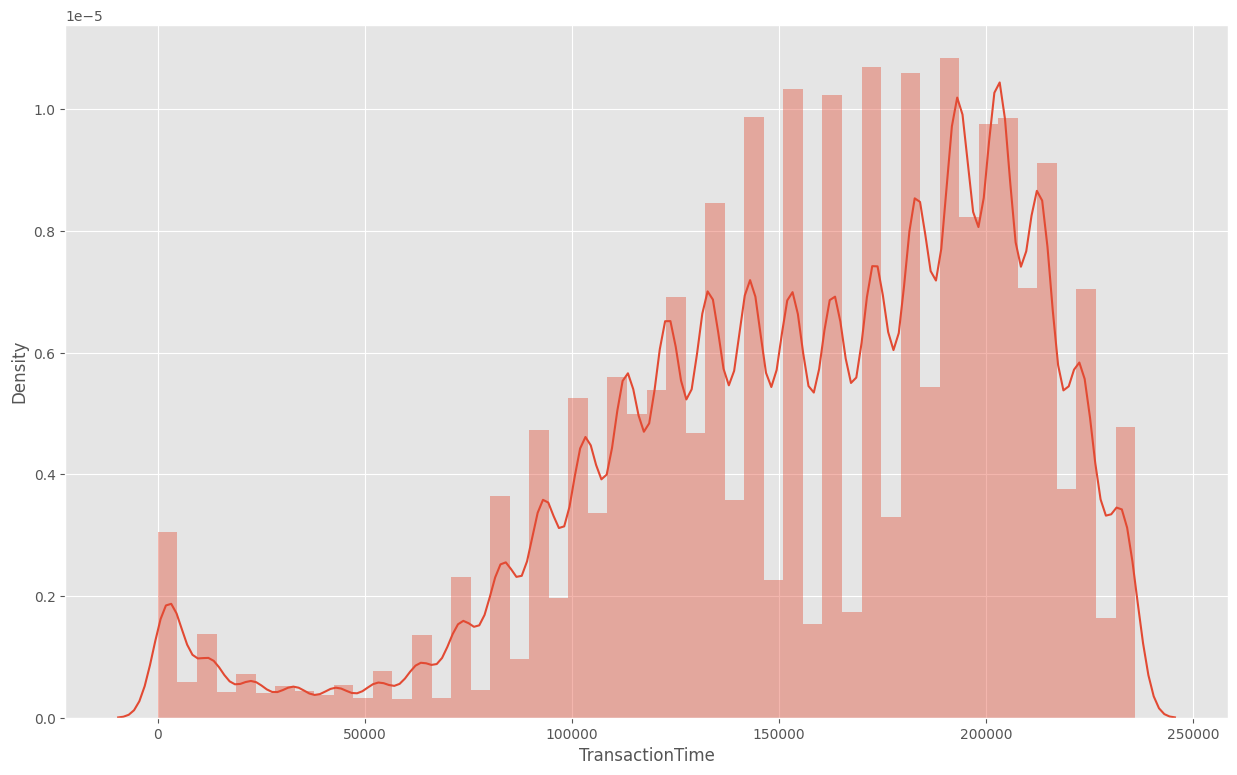

TransactionAmount (INR)


C:\Users\yeyoc\AppData\Local\Temp\ipykernel_9672\638141354.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data[stat])


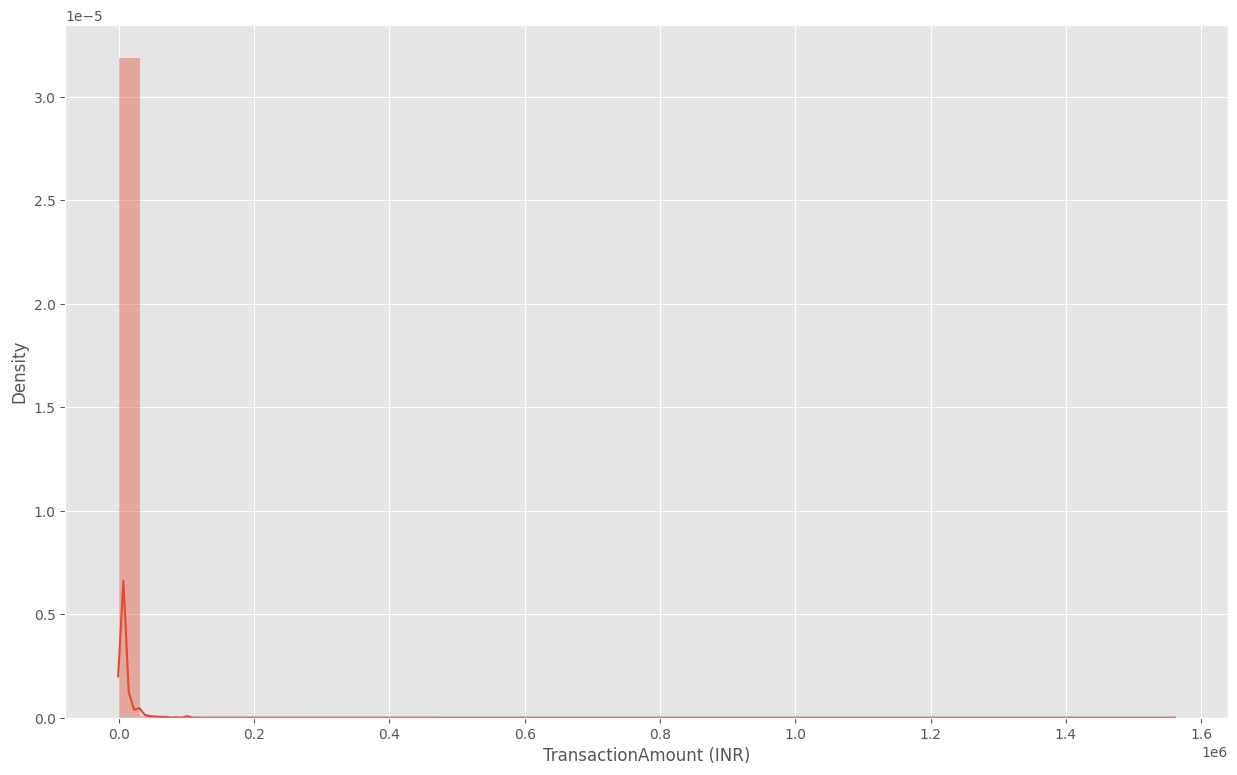

In [420]:
from pandas.api.types import is_numeric_dtype

for stat in data.columns:
    if is_numeric_dtype(data[stat]):
        print(stat)
        sns.distplot(data[stat])
        plt.show()

In [421]:
#sns.pairplot(data)

##### Datos Faltantes
Primero, utilizamos la libreria de seaborn para visualizar los datos faltantes en caso de existir y determinar la forma de rellenarlos o descartarlos.

In [422]:
# Porcentaje de datos nulos del dataset con las columnas esperadas.
null_data = data.isnull().sum()
null_data = null_data / len(data)
perc = null_data.sum() * 100
perc = "{:.2f}".format(perc)
print(perc, '%')

0.67 %


Podemos observar que el porcentaje de datos faltantes del dataset es del 0.67%, lo cual es realmente bajo, a continuación veremos en qué columnas se encuentran estos valores.

Index(['CustomerDOB', 'CustGender', 'CustLocation', 'CustAccountBalance'], dtype='object')

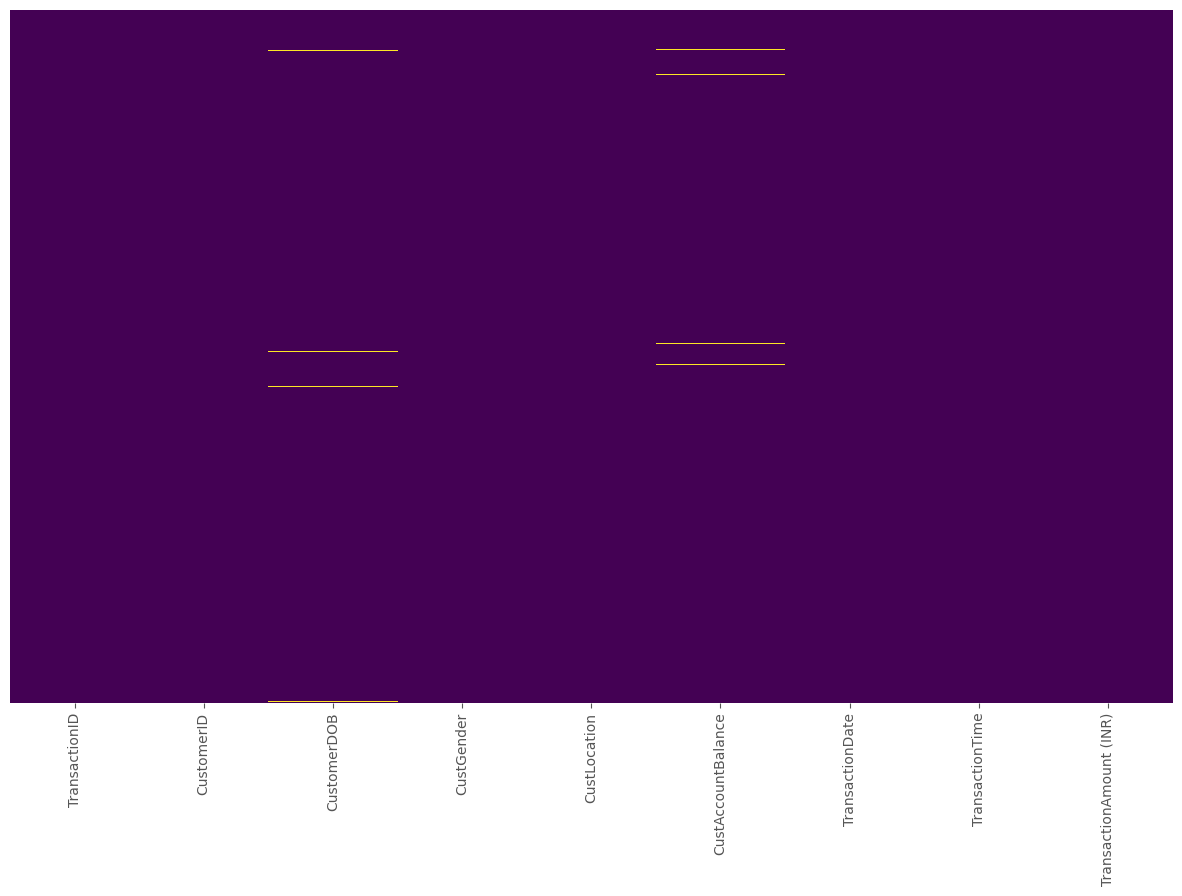

In [423]:
sns.heatmap(data.isnull(), yticklabels = False, cbar = False, cmap = 'viridis')
data.columns[data.isnull().any()]

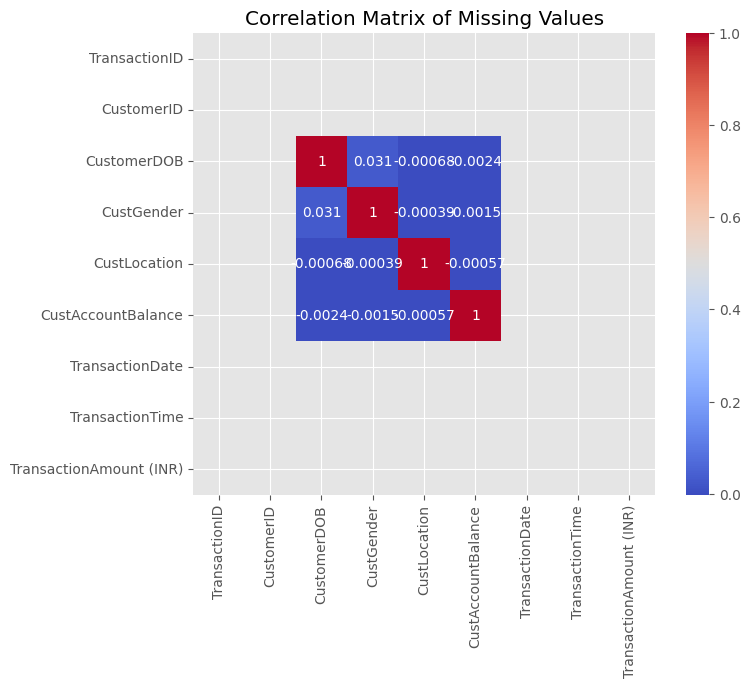

In [424]:
# Coolwarm de la relacion de datos faltantes
missing_corr = data.isnull().corr()
plt.figure(figsize=(8, 6))
sns.heatmap(missing_corr, cmap='coolwarm', annot=True, square=True)
plt.title('Correlation Matrix of Missing Values')
plt.show()


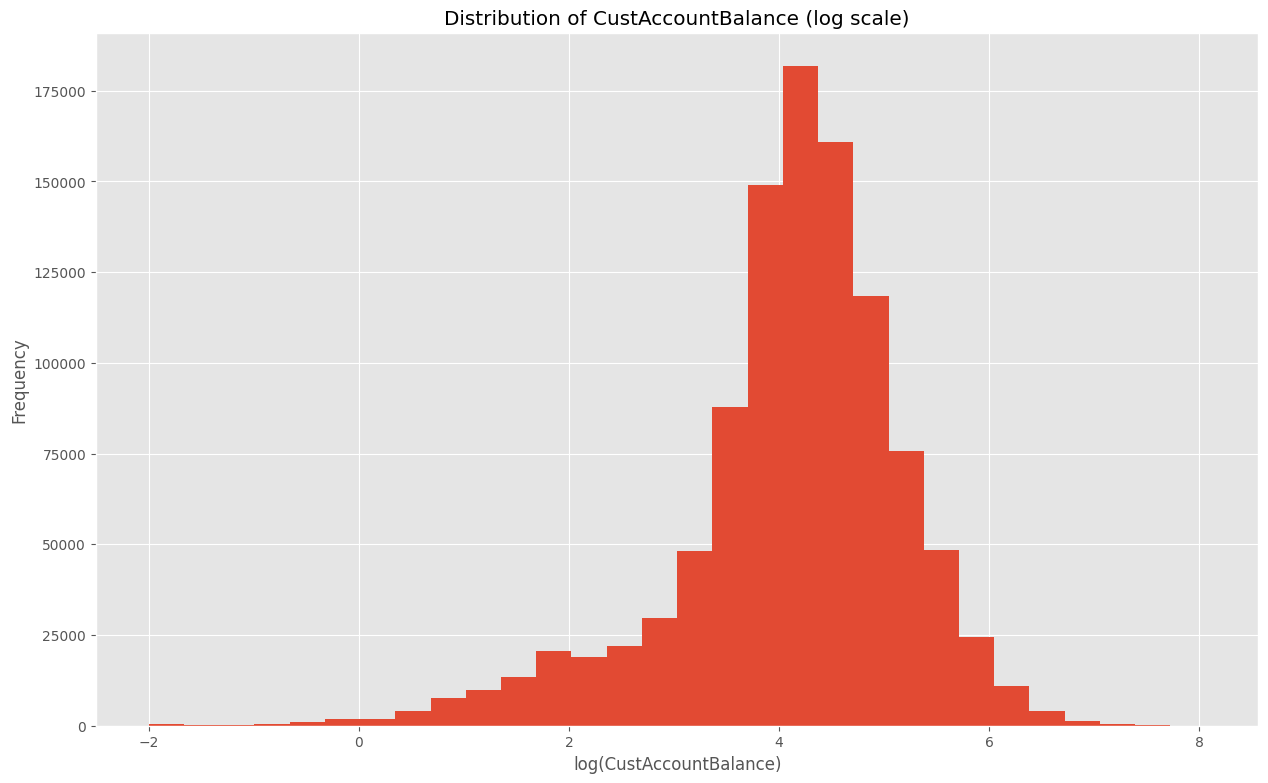

In [425]:
data_clean = data[data['CustAccountBalance'] > 0]
log_data = np.log10(data_clean['CustAccountBalance'])

# Histograma
plt.hist(log_data, bins=30)
plt.xlabel('log(CustAccountBalance)')
plt.ylabel('Frequency')
plt.title('Distribution of CustAccountBalance (log scale)')
plt.show()


Se encontró que los datos faltantes se encuentran mayoritariamente en CustomerDOB y CustAccountBalance, pero también en CustGender y CustLocation. Además, se intentó encontrar una relación para los datos faltantes, pero se encontró que las relaciones no son significativas, por lo que se determinó que los datos faltantes se pueden tratar como aleatorios y se puede rellenar estos datos. <br>
Para CustomerDOB, CustGender y CustLocation, se utilizará la moda porque no son valores continuos. Para CustAccountBalance, se utilizó la media porque son valores numéricos con distribución normal. 

In [426]:
data['CustomerDOB'].fillna(data['CustomerDOB'].mode()[0], inplace=True)
data['CustGender'].fillna(data['CustGender'].mode()[0], inplace=True)
data['CustLocation'].fillna(data['CustLocation'].mode()[0], inplace=True)

data['CustAccountBalance'].fillna(data['CustAccountBalance'].mean(), inplace=True)

data.columns[data.isnull().any()]

Index([], dtype='object')

In [427]:
data.head()

,TransactionID,CustomerID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR)
0,T1,C5841053,10/1/94,F,JAMSHEDPUR,17819.05,2/8/16,143207,25.0
1,T2,C2142763,4/4/57,M,JHAJJAR,2270.69,2/8/16,141858,27999.0
2,T3,C4417068,26/11/96,F,MUMBAI,17874.44,2/8/16,142712,459.0
3,T4,C5342380,14/9/73,F,MUMBAI,866503.21,2/8/16,142714,2060.0
4,T5,C9031234,24/3/88,F,NAVI MUMBAI,6714.43,2/8/16,181156,1762.5


In [428]:
data = data.drop(['TransactionID'], axis=1)
data = data.drop(['TransactionDate'], axis=1) # Todas son 2016
data = data.drop(['CustLocation'], axis=1)

# TODO groupby CustomerID
# TODO Convert DOB to CustAge
# TODO Encode and Gender

In [429]:
data.head()

,CustomerID,CustomerDOB,CustGender,CustAccountBalance,TransactionTime,TransactionAmount (INR)
0,C5841053,10/1/94,F,17819.05,143207,25.0
1,C2142763,4/4/57,M,2270.69,141858,27999.0
2,C4417068,26/11/96,F,17874.44,142712,459.0
3,C5342380,14/9/73,F,866503.21,142714,2060.0
4,C9031234,24/3/88,F,6714.43,181156,1762.5


##### Encoding de variables
Primero, determinamos qué variables debemos convertir y determinar la mejor forma de hacerlo. Para CustomerDOB se determinó que la información de utilidad es la edad y por tanto se reemplazará por este dato. Luego, para CustGender y CustLocation se decidió realizar el proceso de encoding para que fueran numéricas.

In [430]:
data.dtypes

CustomerID                  object
CustomerDOB                 object
CustGender                  object
CustAccountBalance         float64
TransactionTime              int64
TransactionAmount (INR)    float64
dtype: object

In [431]:
data['CustAge'] = '19' + data['CustomerDOB'].str[-2:]
data['CustAge'] = data['CustAge'].astype(int)
data['CustAge'] = 2023 - data['CustAge']

data = data.drop(['CustomerDOB'], axis=1)

In [432]:
le = LabelEncoder()
data = data[data["CustGender"] != "T"]
data["CustGender"] = le.fit_transform(data["CustGender"])

data.head()

,CustomerID,CustGender,CustAccountBalance,TransactionTime,TransactionAmount (INR),CustAge
0,C5841053,0,17819.05,143207,25.0,29
1,C2142763,1,2270.69,141858,27999.0,66
2,C4417068,0,17874.44,142712,459.0,27
3,C5342380,0,866503.21,142714,2060.0,50
4,C9031234,0,6714.43,181156,1762.5,35


In [433]:
data = data.groupby(['CustomerID']).mean()

data.head()

,CustGender,CustAccountBalance,TransactionTime,TransactionAmount (INR),CustAge
CustomerID,,,,,
C1010011,0.5,76340.635,67521.0,2553.0,35.5
C1010012,1.0,24204.490,204409.0,1499.0,29.0
C1010014,0.5,100112.950,187378.0,727.5,35.0
C1010018,0.0,496.180,170254.0,30.0,33.0
C1010024,1.0,87058.650,141103.0,5000.0,58.0


In [434]:
# Pasar data a formato de matriz sin CustomerID
custGender = data['CustGender'].values
custAge = data['CustAge'].values
custAccountBalance = data['CustAccountBalance'].values
transactionAmount = data['TransactionAmount (INR)'].values
transactionType = data['TransactionTime'].values

# combinar en dataset de pandas
data = pd.DataFrame({'CustGender': custGender, 'CustAge': custAge, 'CustAccountBalance': custAccountBalance, 'TransactionAmount (INR)': transactionAmount, 'TransactionTime': transactionType})
data = data[(data['CustGender'] == 0) | (data['CustGender'] == 1)]

data.head()

,CustGender,CustAge,CustAccountBalance,TransactionAmount (INR),TransactionTime
1,1.0,29.0,24204.490,1499.0,204409.0
3,0.0,33.0,496.180,30.0,170254.0
4,1.0,58.0,87058.650,5000.0,141103.0
5,0.0,35.0,296828.370,557.0,95212.0
6,1.0,37.0,5200.155,932.0,162771.5


##### Balanceo de dataset
Debemos verificar qué variables son necesarias de balancear y aplicar una técnica para balancearlas. En este caso, por ser un modelo no supervisado, se determinó que no es necesario este proceso

##### Escalar variables
Para escalar las variables y normalizar se utilizó sklearn. Se decidio utilizar StandardScaler por su capacidad de mantener la relación entre los datos y de mantener el rango de datos original. CustLocation es una variable nominal por lo que se decide no escalarla al igual que CustGender, que además ya se encuentra en un rango de 0 a 1, que en nuestro caso es de mayor utilidad de esta forma.

In [435]:
from sklearn.preprocessing import StandardScaler, normalize

data3 = data.drop(['CustGender'], axis=1)

scaler = StandardScaler()
scaled_features = scaler.fit_transform(data3)
normalized_df = normalize(scaled_features) 

df_feat = pd.DataFrame(normalized_df, columns=data3.columns)
df_feat['CustGender'] = data['CustGender'].values
print(df_feat.head())

    CustAge  CustAccountBalance  TransactionAmount (INR)  TransactionTime   
0 -0.572244           -0.095933                -0.009665         0.814395  \
1 -0.782246           -0.230715                -0.383793         0.433087   
2  0.754764           -0.037091                 0.558087        -0.342775   
3 -0.289142            0.168286                -0.116460        -0.935154   
4 -0.819125           -0.383435                -0.276341         0.325035   

   CustGender  
0         1.0  
1         0.0  
2         1.0  
3         0.0  
4         1.0  


##### Selección de Variables
Para la selección de variables, inicialmente se determinó que las cosas que más nos interesa saber sobre los clientes del banco son el grupo de edad al que pertenecen, sus ingresos y su estilo de vida. Para conocer el grupo de edad y estilo de vida se pensó en usar las columnas CustLocation y CustAge y posiblemente CustGender. Para determinar ingresos y en general las cantidades de dinero que mueven era bastante claro que necesitabamos CustAccountBalance y TransactionAmount, siendo la segunda la más importante. <br>

Adicionalmente, en el caso de Mixture Models, se decidió usar 2 features. Se encontraron los features por medio de PCA, con esto se determinó usar el tiempo de transacción y la edad del cliente.

In [436]:
df_feat.head()

,CustAge,CustAccountBalance,TransactionAmount (INR),TransactionTime,CustGender
0,-0.572244,-0.095933,-0.009665,0.814395,1.0
1,-0.782246,-0.230715,-0.383793,0.433087,0.0
2,0.754764,-0.037091,0.558087,-0.342775,1.0
3,-0.289142,0.168286,-0.116460,-0.935154,0.0
4,-0.819125,-0.383435,-0.276341,0.325035,1.0


In [437]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 2) 
X_pca = pca.fit_transform(df_feat) 
X_pca = pd.DataFrame(X_pca) 
X_pca.columns = ['P1', 'P2'] 

# determinar cuales variables fueron seleccionadas por PCA
selected_variables = []
for component in pca.components_:
    max_index = np.argmax(np.abs(component))
    selected_variables.append(df_feat.columns[max_index])
    
print(selected_variables)

['TransactionTime', 'CustAge']


In [438]:
X_pca     

,P1,P2
0,-0.746719,-0.248401
1,-0.405692,-0.752443
2,0.468972,1.067490
3,0.985377,-0.253830
4,-0.271062,-0.590979
...,...,...
824278,1.071538,0.066623
824279,0.742925,-0.472556
824280,0.779820,-0.436225
824281,-0.761942,-0.226018


##### Mixture Models sin librerias

In [439]:
from scipy.stats import multivariate_normal

def GMM_noLib(X, n_components):
    n_samples, n_features = X.shape

    # Initialize means, covariances, and weights
    cluster_centers = np.random.randn(n_components, n_features)
    cluster_covariances = [np.eye(n_features) for _ in range(n_components)]
    cluster_weights = np.ones(n_components) / n_components
    curr_loglikelihood = 0

    # EM algorithm
    for i in range(20):
        # E-step: Calculate responsibilities
        likelihoods = np.zeros((n_samples, n_components))
        for j in range(n_components):
            likelihoods[:, j] = cluster_weights[j] * multivariate_normal.pdf(X, cluster_centers[j], cluster_covariances[j])
        assignm = likelihoods / np.sum(likelihoods, axis=1, keepdims=True)

        # M-step: Update parameters
        total_assignm = np.sum(assignm, axis=0)
        cluster_weights = total_assignm / n_samples
        cluster_centers = np.dot(assignm.T, X) / total_assignm[:, np.newaxis]
        for j in range(n_components):
            diff = X - cluster_centers[j]
            cluster_covariances[j] = np.dot(assignm[:, j] * diff.T, diff) / total_assignm[j]

        # Check convergence
        log_likelihood = np.sum(np.log(np.sum(likelihoods, axis=1)))
        if i > 0 and np.abs(log_likelihood - curr_loglikelihood) < 0.001:
            break
        curr_loglikelihood = log_likelihood

    # Calculate responsibilities
    likelihoods = np.zeros((n_samples, n_components))
    for j in range(n_components):
        likelihoods[:, j] = cluster_weights[j] * multivariate_normal.pdf(X, cluster_centers[j], cluster_covariances[j])
    assignm = likelihoods / np.sum(likelihoods, axis=1, keepdims=True)

    avg_loglikelihood = curr_loglikelihood / n_samples

    # Assign data points to clusters
    clusters = np.argmax(assignm, axis=1)

    return cluster_centers, cluster_covariances, cluster_weights, clusters, avg_loglikelihood

In [440]:
def calculate_Log_Likelihood(X, kmax=10):
    llh = []
    for k in range(1, kmax+1):
        cluster_centers, cluster_covariances, cluster_weights, clusters, avg_loglikelihood = GMM_noLib(X, n_components=k)
        curr_llh = -avg_loglikelihood
        print("Número de clusters:",k, "   Métrica Log-Likelihood:", curr_llh)
        llh.append(curr_llh)
    return llh

1. No se realiza un split del dataset porque el problema no es de aprendizaje supervisado, lo único que queremos hacer es agrupar los datos que tenemos de la mejor manera posible y no nos interesa que el algoritmo sea bueno haciendo esta agrupación en datos que no ha visto. <br>
2. Para encontrar el número de clusters se decidió usar una gráfica de codo. La manera en que se decidirá por medio de este análisis es utilizando la métrica Log likelihood. Esta métrica nos indica la calidad del agrupamiento por medio de el parentezco entre los clusters que se crean. <br>
3. PCA es una herramienta muy útil para este problema y gracias a ella se encontraron los dos fetures a utilizar en el modelo de GMM.

Número de clusters: 1    Métrica Log-Likelihood: 1.891842395694577
Número de clusters: 2    Métrica Log-Likelihood: 1.468457246612719
Número de clusters: 3    Métrica Log-Likelihood: 1.1843235138091555
Número de clusters: 4    Métrica Log-Likelihood: 1.0644640464739332
Número de clusters: 5    Métrica Log-Likelihood: 0.7321254641876281
Número de clusters: 6    Métrica Log-Likelihood: 0.6629306000106268
Número de clusters: 7    Métrica Log-Likelihood: 0.593139869510254
Número de clusters: 8    Métrica Log-Likelihood: 0.5865420695166662


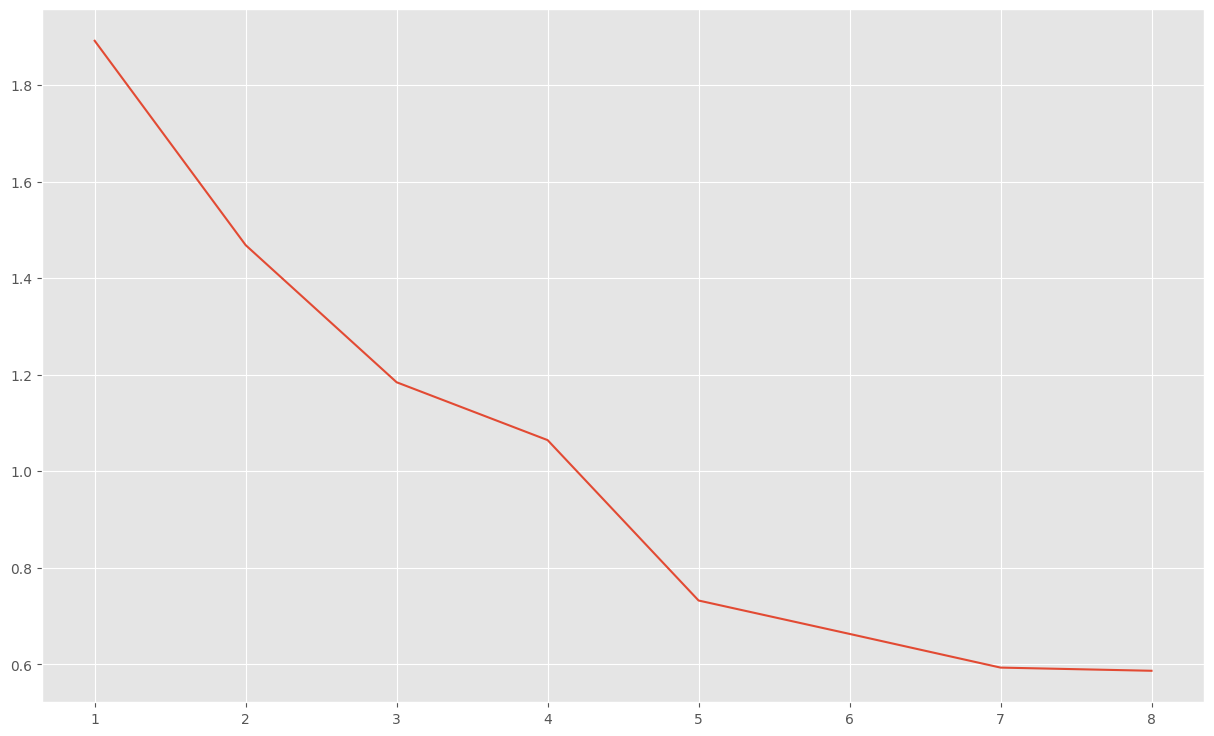

In [441]:
X_pca = X_pca.sample(frac=1).reset_index(drop=True)
llh = calculate_Log_Likelihood(X_pca, kmax=8)

fig = plt.figure()
ax = plt.axes()
x_plot = list(range(1, 9))
ax.plot(x_plot, llh)

C:\Users\yeyoc\AppData\Local\Temp\ipykernel_9672\3137679976.py:18: MatplotlibDeprecationWarning: Passing the angle parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  ellipse = Ellipse(pos, nsig * width, nsig * height, angle)


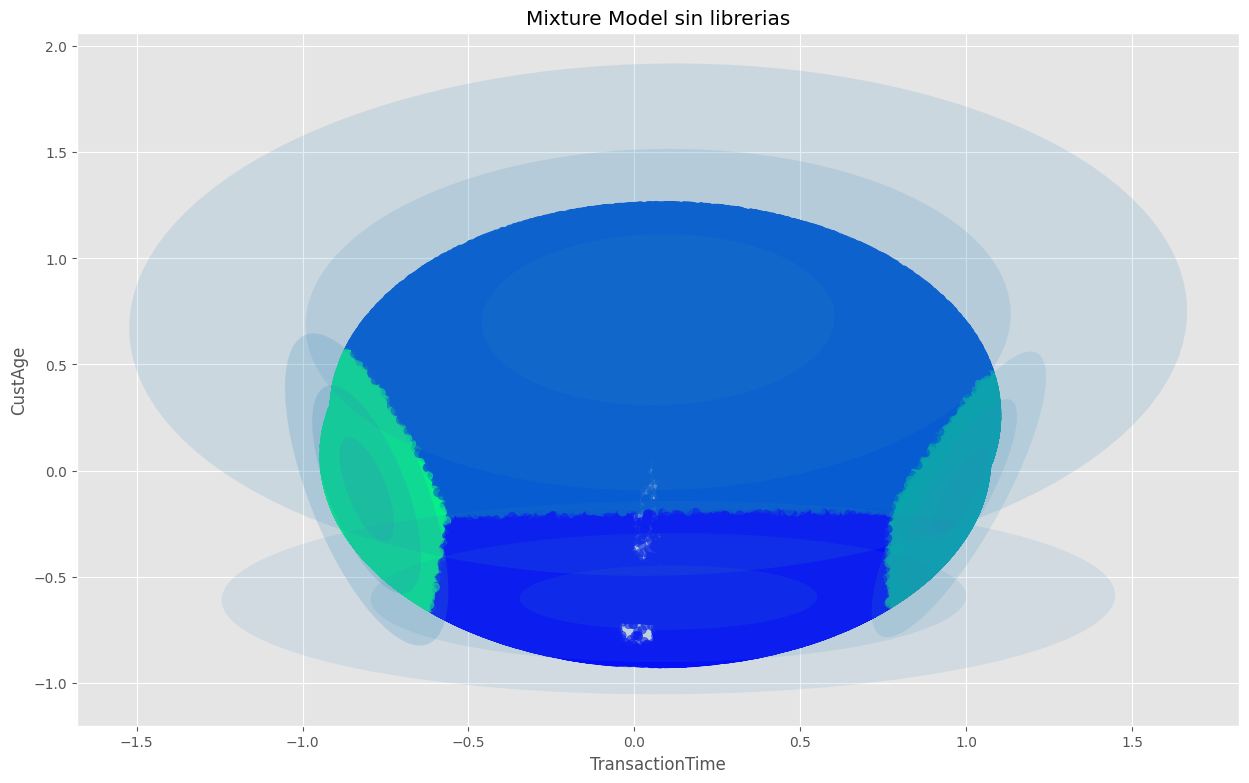

In [442]:
cluster_centers, cluster_covariances, cluster_weights, clusters, avg_loglikelihood = GMM_noLib(X_pca, n_components=4)

plt.scatter(X_pca['P1'], X_pca['P2'], c = clusters, cmap =plt.cm.winter, alpha = 0.6) 
from matplotlib.patches import Ellipse
w_factor = 0.2 / max(cluster_weights)

for pos, covarianza, w in zip(cluster_centers, cluster_covariances, cluster_weights):
    w2 = w * w_factor
    if covarianza.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covarianza)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covarianza)

    for nsig in range(1, 4):
        ellipse = Ellipse(pos, nsig * width, nsig * height, angle)
        ellipse.set_alpha(w2)
        plt.gca().add_patch(ellipse)

plt.xlabel('TransactionTime')
plt.ylabel('CustAge')
plt.title('Mixture Model sin librerias')
plt.show()

In [455]:
cluster_centers, cluster_covariances, cluster_weights, clusters, avg_loglikelihood = GMM_noLib(X_pca, n_components=4)

print("DBI:", metrics.davies_bouldin_score(X_pca, clusters))
print("CHI:", metrics.calinski_harabasz_score(X_pca, clusters))

DBI: 1.0842441524632034
CHI: 677897.9307135529


In [444]:
from sklearn.mixture import GaussianMixture

def calculate_Log_Likelihood_w_GMM(X, kmax=10):
    llh = []
    for k in range(1, kmax+1):
        gmm = GaussianMixture(n_components = k)
        gmm.fit(X)
        curr_llh = -gmm.score(X)
        print("Número de clusters:",k, "   Métrica Log-Likelihood:", curr_llh)
        llh.append(curr_llh)
    return llh

Número de clusters: 1    Métrica Log-Likelihood: 1.8918423956987749
Número de clusters: 2    Métrica Log-Likelihood: 1.3382799706034234
Número de clusters: 3    Métrica Log-Likelihood: 1.0957586435019824
Número de clusters: 4    Métrica Log-Likelihood: 0.7690068778351415
Número de clusters: 5    Métrica Log-Likelihood: 0.6855238398816543
Número de clusters: 6    Métrica Log-Likelihood: 0.6305850775400906
Número de clusters: 7    Métrica Log-Likelihood: 0.5621179609093113
Número de clusters: 8    Métrica Log-Likelihood: 0.505254386225889


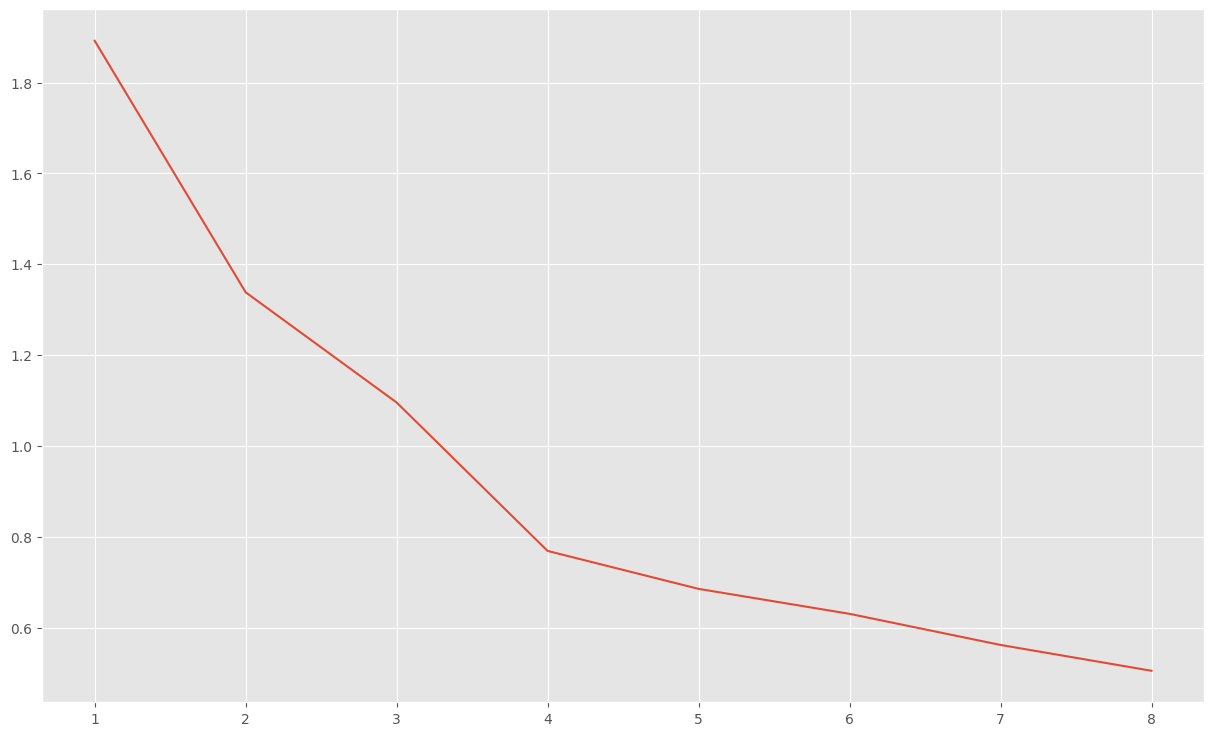

In [445]:
llh = calculate_Log_Likelihood_w_GMM(X_pca, kmax=8)
fig = plt.figure()
ax = plt.axes()
x_plot = list(range(1, 9))
ax.plot(x_plot, llh)

C:\Users\yeyoc\AppData\Local\Temp\ipykernel_9672\64170561.py:20: MatplotlibDeprecationWarning: Passing the angle parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  ellipse = Ellipse(pos, nsig * width, nsig * height, angle)


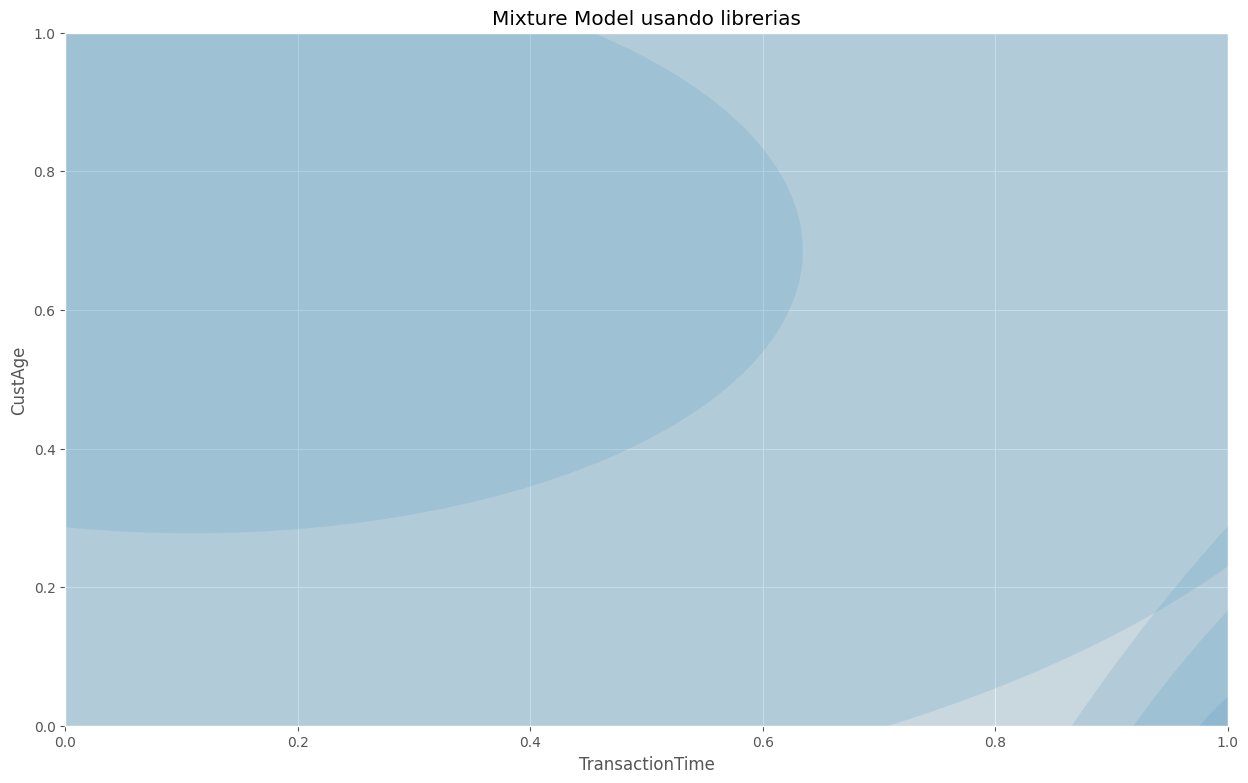

In [457]:
gmm = GaussianMixture(n_components = 4) 
gmm.fit(X_pca)

means = gmm.means_
covariances = gmm.covariances_
weights = gmm.weights_
w_factor = 0.2 / gmm.weights_.max()

for pos, covarianza, w in zip(gmm.means_, gmm.covariances_, gmm.weights_):
    w2 = w * w_factor
    if covarianza.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covarianza)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covarianza)

    for nsig in range(1, 4):
        ellipse = Ellipse(pos, nsig * width, nsig * height, angle)
        ellipse.set_alpha(w2)
        plt.gca().add_patch(ellipse)

plt.xlabel('TransactionTime')
plt.ylabel('CustAge')
plt.title('Mixture Model usando librerias')
plt.show()

In [452]:
                                             
print("DBI:", metrics.davies_bouldin_score(X_pca, GaussianMixture(n_components = 4).fit_predict(X_pca)))
print("CHI:", metrics.calinski_harabasz_score(X_pca, GaussianMixture(n_components = 4).fit_predict(X_pca)))

DBI: 0.7402639889590026
CHI: 988554.4279913001
